In [23]:
#Autoreload to be able to tweak source code in the fly without restarting kernel
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
%autoreload 2

In [25]:
%matplotlib inline
import aligater as ag

In [26]:
fcsDF = ag.loadFCS("/media/ludvig/Project_Storage/GAIM/data/GAIM_fcs/01-03-2016/plate 1/B cells_A2_A02_030.fcs")

Loaded dataset with 279440 events.
Marker labels: IgA CD27 CD34 CD19 IgD CD45 CD38 CD24 

Completely ungated

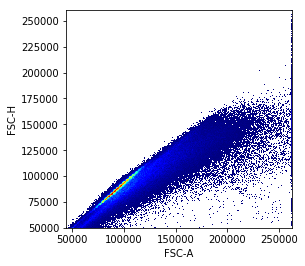

In [34]:
fig, ax = ag.plotHeatmap(fcsDF,"FSC-A", "FSC-H")
ag.plt.show();

Lets remove those stacked values along the far right edge

277035


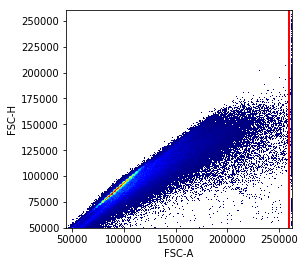

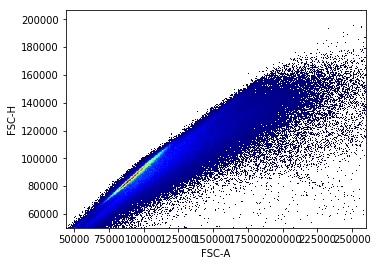

After gating, 277035 out of 279440 events remain.

In [28]:
no_clutter=ag.gateThreshold(fcsDF,"FSC-A", "FSC-H",thresh=260000, orientation='horisontal',population="lower", plot=True)

After gating, 259345 out of 277035 events remain.

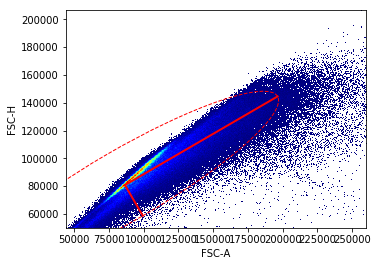

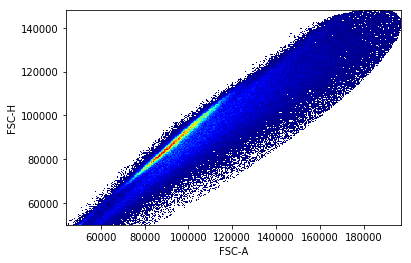

In [29]:
singlets=ag.gatePC(fcsDF,"FSC-A", "FSC-H",center='density',widthScale=3, heightScale=3, vI=no_clutter, plot=True)

After gating, 269777 out of 277035 events remain.

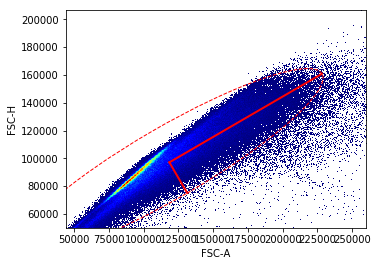

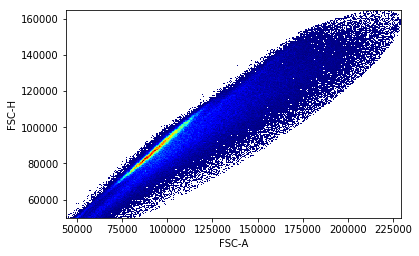

In [30]:
singlets=ag.gatePC(fcsDF,"FSC-A", "FSC-H",center='centroid',widthScale=3, heightScale=3,vI=no_clutter, plot=True)

After gating, 260664 out of 277035 events remain.

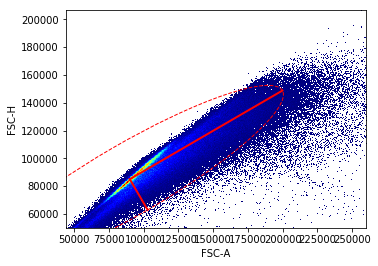

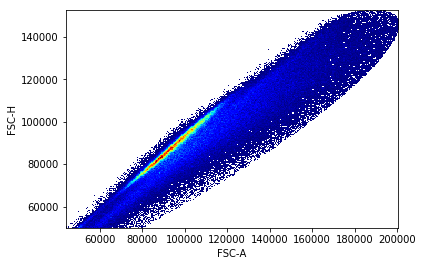

In [31]:
singlets=ag.gatePC(fcsDF,"FSC-A", "FSC-H",center='custom',customCenter=[90000,85000],widthScale=3, heightScale=3,vI=no_clutter, plot=True)

In [32]:
gmm=ag.gmm2D(fcsDF, "FSC-A", "FSC-H", nOfComponents=1, vI=no_clutter)

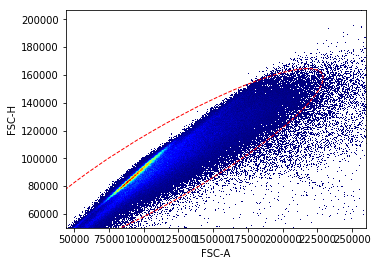

[array([ 118482.42264484,   97096.39170502]), 84646.800107908144, 17049.843424153332, -149.86170932665141]


In [35]:
ag.gateGMM(fcsDF, "FSC-A", "FSC-H", gmm, no_clutter, sigma=3);